In [62]:
import os
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

from nilearn.plotting import plot_connectome
import networkx as nx


In [63]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

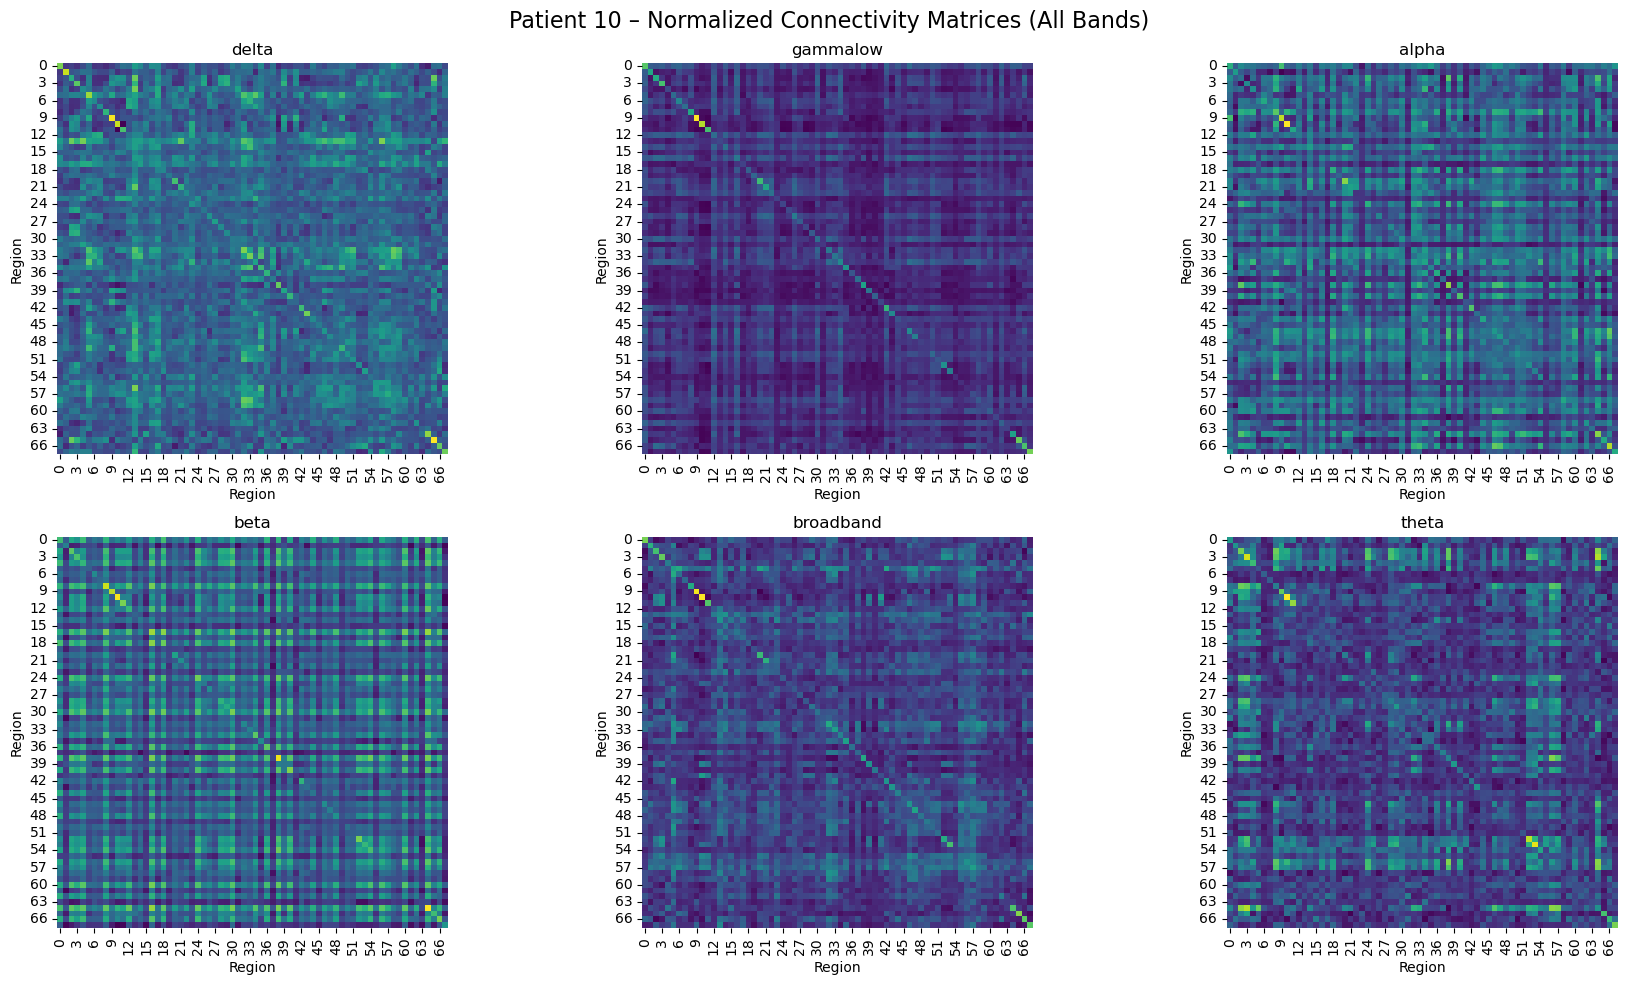

Loaded 71 graphs.


In [64]:
base_directory = "/Users/sogandghasemi/Documents/uni/Stage/project/data"
frequency_bands = ['delta', 'gammalow', 'alpha', 'beta', 'broadband', 'theta']
num_nodes = 68

graph_list = []
plotted = False  # Plot only once

for patient_id in range(8, 277):
    patient_directory = os.path.join(base_directory, f"p{patient_id}")
    
    if not os.path.exists(patient_directory):
        continue

    edge_features_list = []
    conn_matrices = []  # Store numpy matrices for plotting
    
    for band in frequency_bands:
        file_path = os.path.join(patient_directory, f"{band}_connectivity.csv")
        if not os.path.exists(file_path):
            break

        matrix = pd.read_csv(file_path, index_col=0).values.astype('float32')
        max_val = matrix.max()
        normalized = matrix / max_val if max_val > 0 else matrix
        tensor = torch.tensor(normalized)
        
        edge_features_list.append(tensor)
        conn_matrices.append(normalized)  # store for visualization

    if len(edge_features_list) != 6:
        continue

    # Plot normalized heatmaps for just one patient
    if patient_id == 10 and not plotted:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        for i, ax in enumerate(axes.flat):
            sns.heatmap(conn_matrices[i], ax=ax, cmap='viridis', square=True, cbar=False)
            ax.set_title(frequency_bands[i])
            ax.set_xlabel("Region")
            ax.set_ylabel("Region")
        plt.suptitle(f"Patient {patient_id} – Normalized Connectivity Matrices (All Bands)", fontsize=16)
        plt.tight_layout()
        plt.show()
        plotted = True

    # Convert to stacked tensor [6, 68, 68]
    conn_matrices_tensor = torch.stack(edge_features_list)

    # Build edge list
    edge_index = []
    edge_attr = []

    for i in range(num_nodes):
        for j in range(i, num_nodes):
            edge_index.append([i, j])
            edge_attr.append(conn_matrices_tensor[:, i, j])
            if i != j:
                edge_index.append([j, i])
                edge_attr.append(conn_matrices_tensor[:, i, j])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.stack(edge_attr)
    x = torch.ones(num_nodes, 1)

    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    graph_list.append(graph)

print(f"Loaded {len(graph_list)} graphs.")


In [65]:
print(graph_list[0])


Data(x=[68, 1], edge_index=[2, 4624], edge_attr=[4624, 6])


In [66]:
len(graph_list)

71

In [67]:
class BrainEdgeConv(MessagePassing):
    def __init__(self, node_in_dim=1, edge_in_dim=6, out_dim=32):
        super().__init__(aggr='mean')
        self.mlp = nn.Sequential(
            nn.Linear(2 * node_in_dim + edge_in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim)
        )

    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr) #finds neighbors for each node

    def message(self, x_i, x_j, edge_attr): #gets the message from each neighbor
        input = torch.cat([x_i, x_j, edge_attr], dim=1) #concatenates the node features, neighbor features, and edge features
        return self.mlp(input)

    def update(self, aggr_out): #updates the node with the average of the messages
        return aggr_out


In [68]:
# 1-layer model
class EdgeRegressionGNN1Layer(nn.Module):
    def __init__(self, node_in_dim=1, edge_in_dim=6, hidden_dim=32, out_dim=6):
        super().__init__()
        self.gnn = BrainEdgeConv(node_in_dim, edge_in_dim, hidden_dim)
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim)
        )

    def forward(self, x, edge_index, edge_attr, edge_index_to_predict=None):
        x = self.gnn(x, edge_index, edge_attr)
        x = torch.relu(x)

        if edge_index_to_predict is None:
            edge_index_to_predict = edge_index

        src = edge_index_to_predict[0]
        dst = edge_index_to_predict[1]
        h_src = x[src]
        h_dst = x[dst]
        edge_input = torch.cat([h_src, h_dst], dim=1)

        return self.edge_mlp(edge_input)




In [69]:

class EdgeRegressionGNN(nn.Module):
    def __init__(self, node_in_dim=1, edge_in_dim=6, hidden_dim=32, out_dim=6):
        super().__init__() 
        
        # Two stacked message-passing layers
        self.gnn1 = BrainEdgeConv(node_in_dim, edge_in_dim, hidden_dim)
        self.gnn2 = BrainEdgeConv(hidden_dim, edge_in_dim, hidden_dim)

        # MLP to predict edge attributes from node pairs
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim)
        )

    def forward(self, x, edge_index, edge_attr, edge_index_to_predict=None):
        # First message passing layer
        x = self.gnn1(x, edge_index, edge_attr)
        x = torch.relu(x)

        # Second message passing layer
        x = self.gnn2(x, edge_index, edge_attr)
        x = torch.relu(x)

        # Default: predict for all edges in edge_index
        if edge_index_to_predict is None:
            edge_index_to_predict = edge_index

        src = edge_index_to_predict[0]
        dst = edge_index_to_predict[1]

        h_src = x[src] 
        h_dst = x[dst]
        edge_input = torch.cat([h_src, h_dst], dim=1)

        return self.edge_mlp(edge_input)


In [70]:
EdgeRegressionGNN2Layer = EdgeRegressionGNN

In [72]:
train_graphs, test_graphs = train_test_split(graph_list, test_size=0.1, random_state=SEED)

print(f"Training graphs: {len(train_graphs)}")
print(f"Test graphs:     {len(test_graphs)}")


Training graphs: 63
Test graphs:     8


In [36]:
selected_out = torch.randperm(int(68*68/2 + 68/2))


In [73]:

def mask_edges(graph, mask_ratio=0.05):
    edge_index = graph.edge_index
    edge_attr = graph.edge_attr
    num_edges = edge_index.size(1)

    # Step 1: Convert edges to undirected pairs (min(i,j), max(i,j))
    i = edge_index[0]
    j = edge_index[1]
    undirected_edges = torch.stack([torch.minimum(i, j), torch.maximum(i, j)], dim=1)  # [E, 2]

    # Step 2: Identify unique undirected edges
    unique_edges, inverse = torch.unique(undirected_edges, dim=0, return_inverse=True)
    num_unique = unique_edges.size(0)

    # Step 3: Randomly select a subset of unique edges to mask
    num_to_mask = int(mask_ratio * num_unique)
    selected = torch.randperm(num_unique)[:num_to_mask]
    #selected = torch.linspace(0, num_unique, num_unique)[:num_to_mask].int()
    #selected = selected_out[:num_to_mask].int()
    selected_mask = torch.zeros(num_unique, dtype=torch.bool)
    selected_mask[selected] = True

    # Step 4: Use inverse mapping to mask both directions of selected undirected edges
    is_masked = selected_mask[inverse]

    # Step 5: Create masked and unmasked edge sets
    keep_idx = ~is_masked
    mask_idx = is_masked

    masked_edge_index = edge_index[:, keep_idx]
    masked_edge_attr = edge_attr[keep_idx]

    target_edge_index = edge_index[:, mask_idx]
    target_edge_attr = edge_attr[mask_idx]

    return masked_edge_index, masked_edge_attr, target_edge_index, target_edge_attr


In [54]:
graph = train_graphs[0]

masked_edge_index, masked_edge_attr, target_edge_index, target_edge_attr = mask_edges(graph, mask_ratio=0.05)

print("Original number of edges:", graph.edge_index.shape[1])
print("Remaining (visible) edges:", masked_edge_index.shape[1])
print("Masked (target) edges:   ", target_edge_index.shape[1])


Original number of edges: 4624
Remaining (visible) edges: 4394
Masked (target) edges:    230


In [26]:
target_edge_attr.shape

torch.Size([4624, 6])

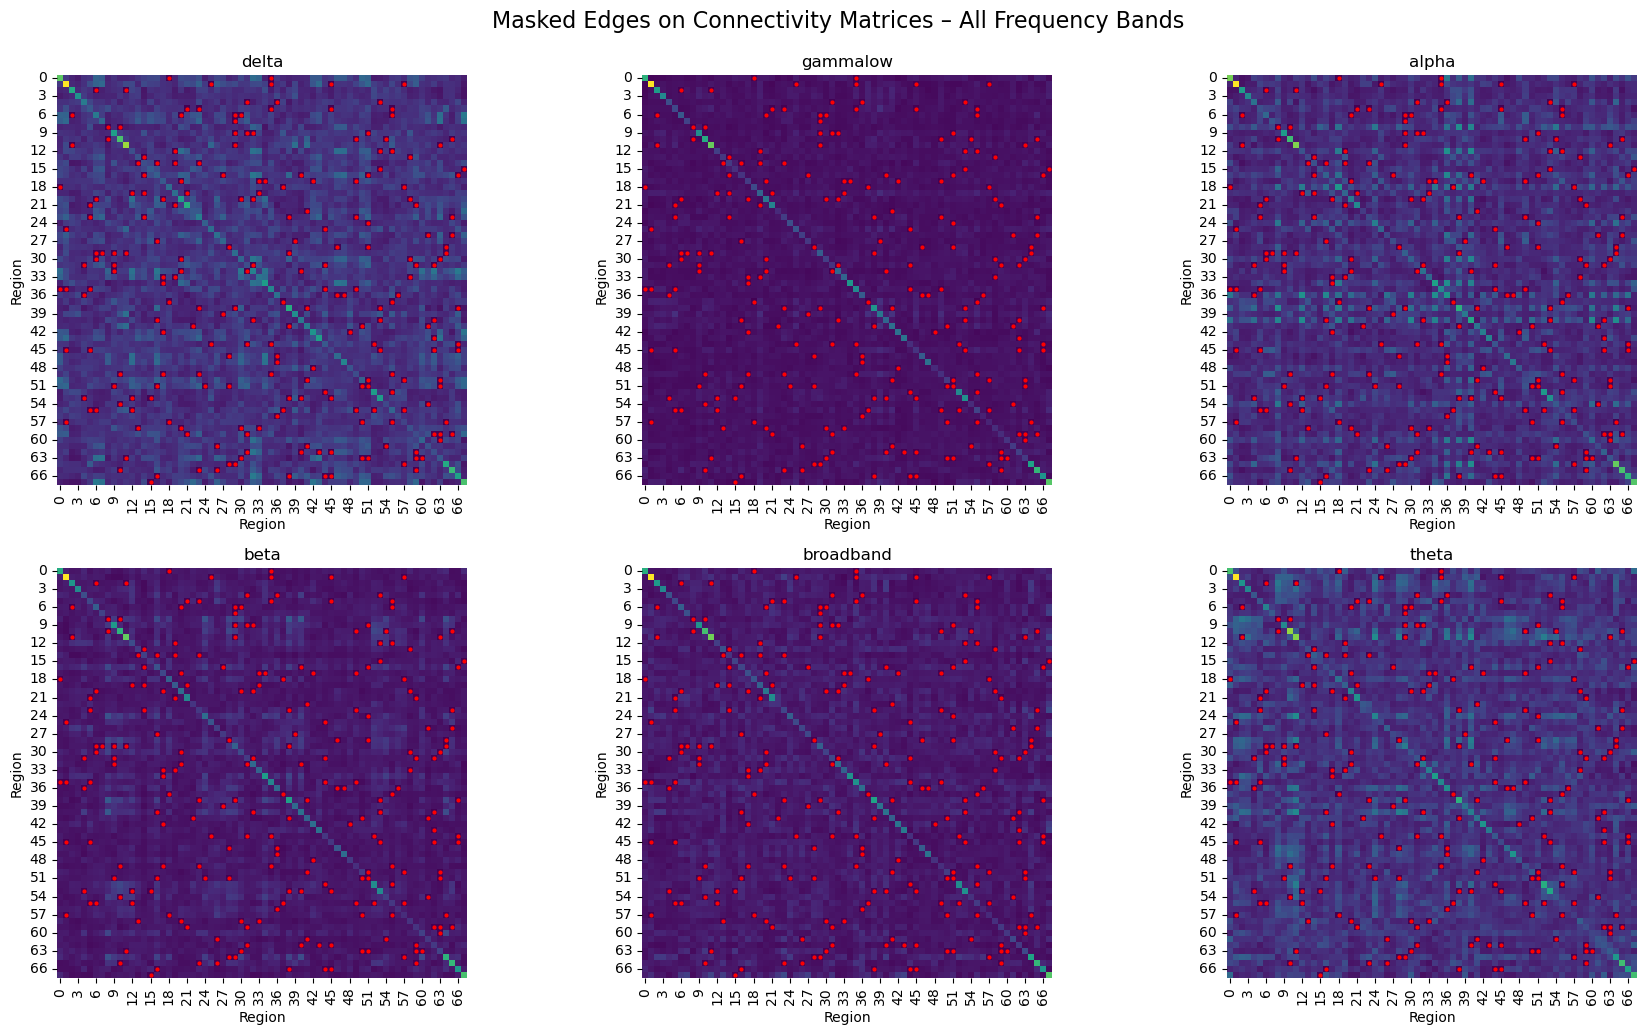

In [55]:
bands = ['delta', 'gammalow', 'alpha', 'beta', 'broadband', 'theta']
num_nodes = graph.x.shape[0]

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Loop over each frequency band
for band_index in range(6):
    band_name = bands[band_index]

    # Reconstruct matrix from visible edges
    matrix = torch.zeros(num_nodes, num_nodes)
    for k in range(masked_edge_index.shape[1]):
        i = masked_edge_index[0, k]
        j = masked_edge_index[1, k]
        matrix[i, j] = masked_edge_attr[k, band_index]

    # Plot heatmap
    ax = axes[band_index]
    sns.heatmap(matrix.numpy(), ax=ax, cmap='viridis', square=True, cbar=False)
    ax.set_title(f"{band_name}")

    # Overlay red dots for masked edges
    for k in range(target_edge_index.shape[1]):
        i = target_edge_index[0, k].item()
        j = target_edge_index[1, k].item()
        ax.plot(j + 0.5, i + 0.5, 'ro', markersize=2)

    ax.set_xlabel("Region")
    ax.set_ylabel("Region")

plt.tight_layout()
plt.suptitle("Masked Edges on Connectivity Matrices – All Frequency Bands", fontsize=16, y=1.03)
plt.show()


In [56]:
def train_model(model, train_graphs, num_epochs=50, mask_ratio=0.05, lr=0.001):
    model = model.to("cpu")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    loss_history = []  # Store average loss per epoch

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for graph in train_graphs:
            optimizer.zero_grad()

            masked_edge_index, masked_edge_attr, target_edge_index, target_edge_attr = mask_edges(graph, mask_ratio)

            pred = model(
                graph.x,
                masked_edge_index,
                masked_edge_attr,
                edge_index_to_predict=target_edge_index
            )

            loss = loss_fn(pred, target_edge_attr)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_graphs)
        loss_history.append(avg_loss)

        print(f"[{model.__class__.__name__}] Epoch {epoch+1}/{num_epochs} – Avg Loss: {avg_loss:.4f}")

    return model, loss_history


In [57]:
def evaluate_model(model, test_graphs, mask_ratio=0.05, model_name="GNN"):
    model.eval()
    frequency_bands = ['delta', 'gammalow', 'alpha', 'beta', 'broadband', 'theta']
    all_preds, all_trues = [], []
    total_mse = total_mae = total_count = 0

    with torch.no_grad():
        for graph in test_graphs:
            graph = graph.to("cpu")

            masked_edge_index, masked_edge_attr, target_edge_index, target_edge_attr = mask_edges(graph, mask_ratio)

            pred = model(
                graph.x,
                masked_edge_index,
                masked_edge_attr,
                edge_index_to_predict=target_edge_index
            )

            all_preds.append(pred.cpu())
            all_trues.append(target_edge_attr.cpu())

            total_mse += F.mse_loss(pred, target_edge_attr, reduction='sum').item()
            total_mae += F.l1_loss(pred, target_edge_attr, reduction='sum').item()
            total_count += pred.shape[0]

    # === Final Metrics ===
    avg_mse = total_mse / total_count
    avg_mae = total_mae / total_count
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_trues = torch.cat(all_trues, dim=0).numpy()

    print(f"\n📊 Evaluation Results – {model_name}")
    print(f"MSE: {avg_mse:.6f}")
    print(f"MAE: {avg_mae:.6f}")

    # === Plot Predicted vs True ===
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, band in enumerate(frequency_bands):
        preds = all_preds[:, i]
        trues = all_trues[:, i]

        ax = axes[i]
        ax.scatter(trues, preds, alpha=0.5, s=10)
        ax.plot([0, 1], [0, 1], 'r--', linewidth=1)

        corr = np.corrcoef(trues, preds)[0, 1]
        mse_band = np.mean((preds - trues) ** 2)

        ax.set_title(f"{band} (Corr: {corr:.2f}, MSE: {mse_band:.4f})")
        ax.set_xlabel("True")
        ax.set_ylabel("Predicted")
        ax.grid(True, alpha=0.3)
  
    print(f"\nTotal masked edges predicted: {total_count} → {total_count} points per band")

    plt.tight_layout()
    plt.suptitle(f"{model_name} – Predicted vs True on Masked Edges", fontsize=16, y=1.03)
    plt.show()

    return avg_mse, avg_mae, all_preds, all_trues


In [58]:
model_1layer, loss_1layer = train_model(EdgeRegressionGNN1Layer(), train_graphs)
model_2layer, loss_2layer = train_model(EdgeRegressionGNN2Layer(), train_graphs)




[EdgeRegressionGNN1Layer] Epoch 1/50 – Avg Loss: 0.0194
[EdgeRegressionGNN1Layer] Epoch 2/50 – Avg Loss: 0.0141
[EdgeRegressionGNN1Layer] Epoch 3/50 – Avg Loss: 0.0099
[EdgeRegressionGNN1Layer] Epoch 4/50 – Avg Loss: 0.0090
[EdgeRegressionGNN1Layer] Epoch 5/50 – Avg Loss: 0.0088
[EdgeRegressionGNN1Layer] Epoch 6/50 – Avg Loss: 0.0085
[EdgeRegressionGNN1Layer] Epoch 7/50 – Avg Loss: 0.0085
[EdgeRegressionGNN1Layer] Epoch 8/50 – Avg Loss: 0.0081
[EdgeRegressionGNN1Layer] Epoch 9/50 – Avg Loss: 0.0077
[EdgeRegressionGNN1Layer] Epoch 10/50 – Avg Loss: 0.0068
[EdgeRegressionGNN1Layer] Epoch 11/50 – Avg Loss: 0.0060
[EdgeRegressionGNN1Layer] Epoch 12/50 – Avg Loss: 0.0060
[EdgeRegressionGNN1Layer] Epoch 13/50 – Avg Loss: 0.0059
[EdgeRegressionGNN1Layer] Epoch 14/50 – Avg Loss: 0.0057
[EdgeRegressionGNN1Layer] Epoch 15/50 – Avg Loss: 0.0055
[EdgeRegressionGNN1Layer] Epoch 16/50 – Avg Loss: 0.0056
[EdgeRegressionGNN1Layer] Epoch 17/50 – Avg Loss: 0.0053
[EdgeRegressionGNN1Layer] Epoch 18/50 – 

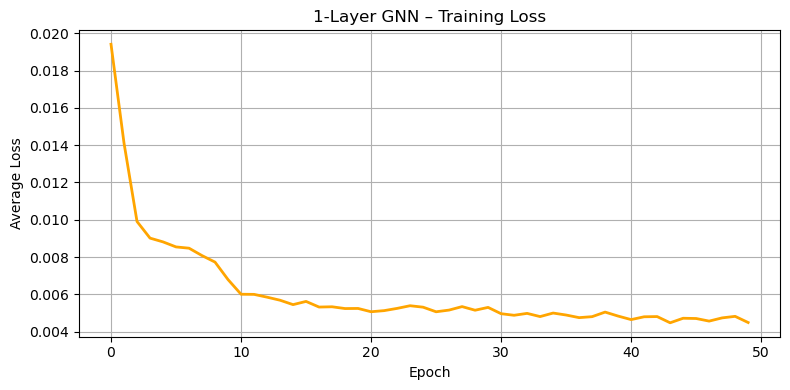

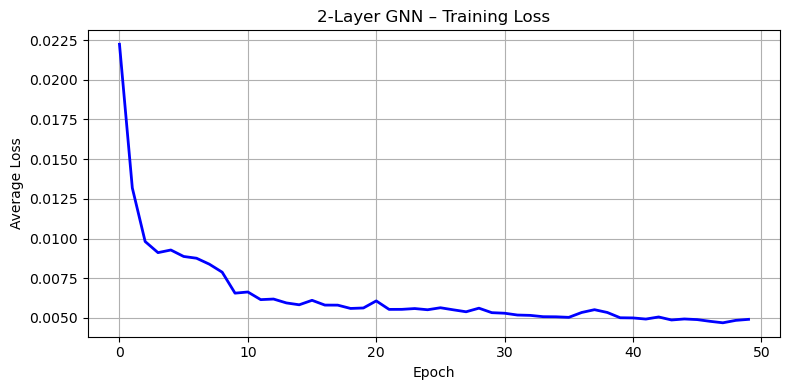

In [59]:
# === Plot 1-Layer GNN Learning Curve ===
plt.figure(figsize=(8, 4))
plt.plot(loss_1layer, color='orange', linewidth=2)
plt.title("1-Layer GNN – Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2-Layer GNN Learning Curve ===
plt.figure(figsize=(8, 4))
plt.plot(loss_2layer, color='blue', linewidth=2)
plt.title("2-Layer GNN – Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


📊 Evaluation Results – 1-Layer GNN
MSE: 0.030030
MAE: 0.301772

Total masked edges predicted: 1848 → 1848 points per band


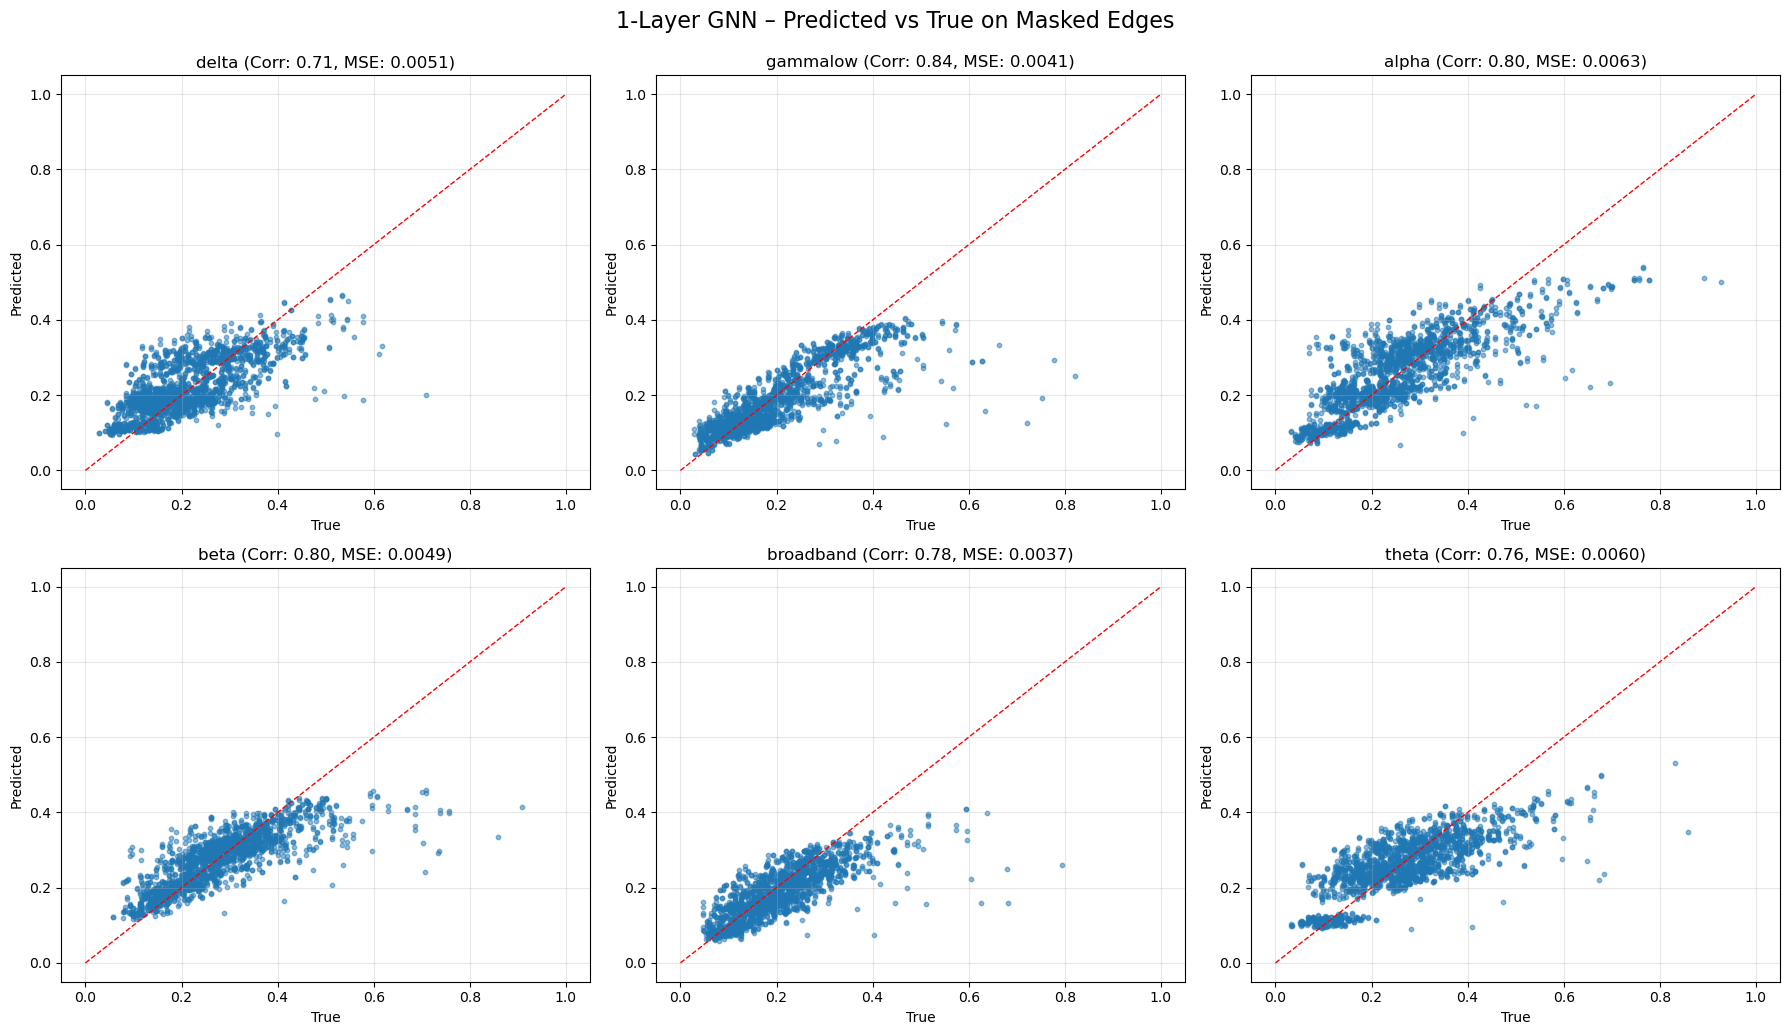


📊 Evaluation Results – 2-Layer GNN
MSE: 0.032100
MAE: 0.312887

Total masked edges predicted: 1854 → 1854 points per band


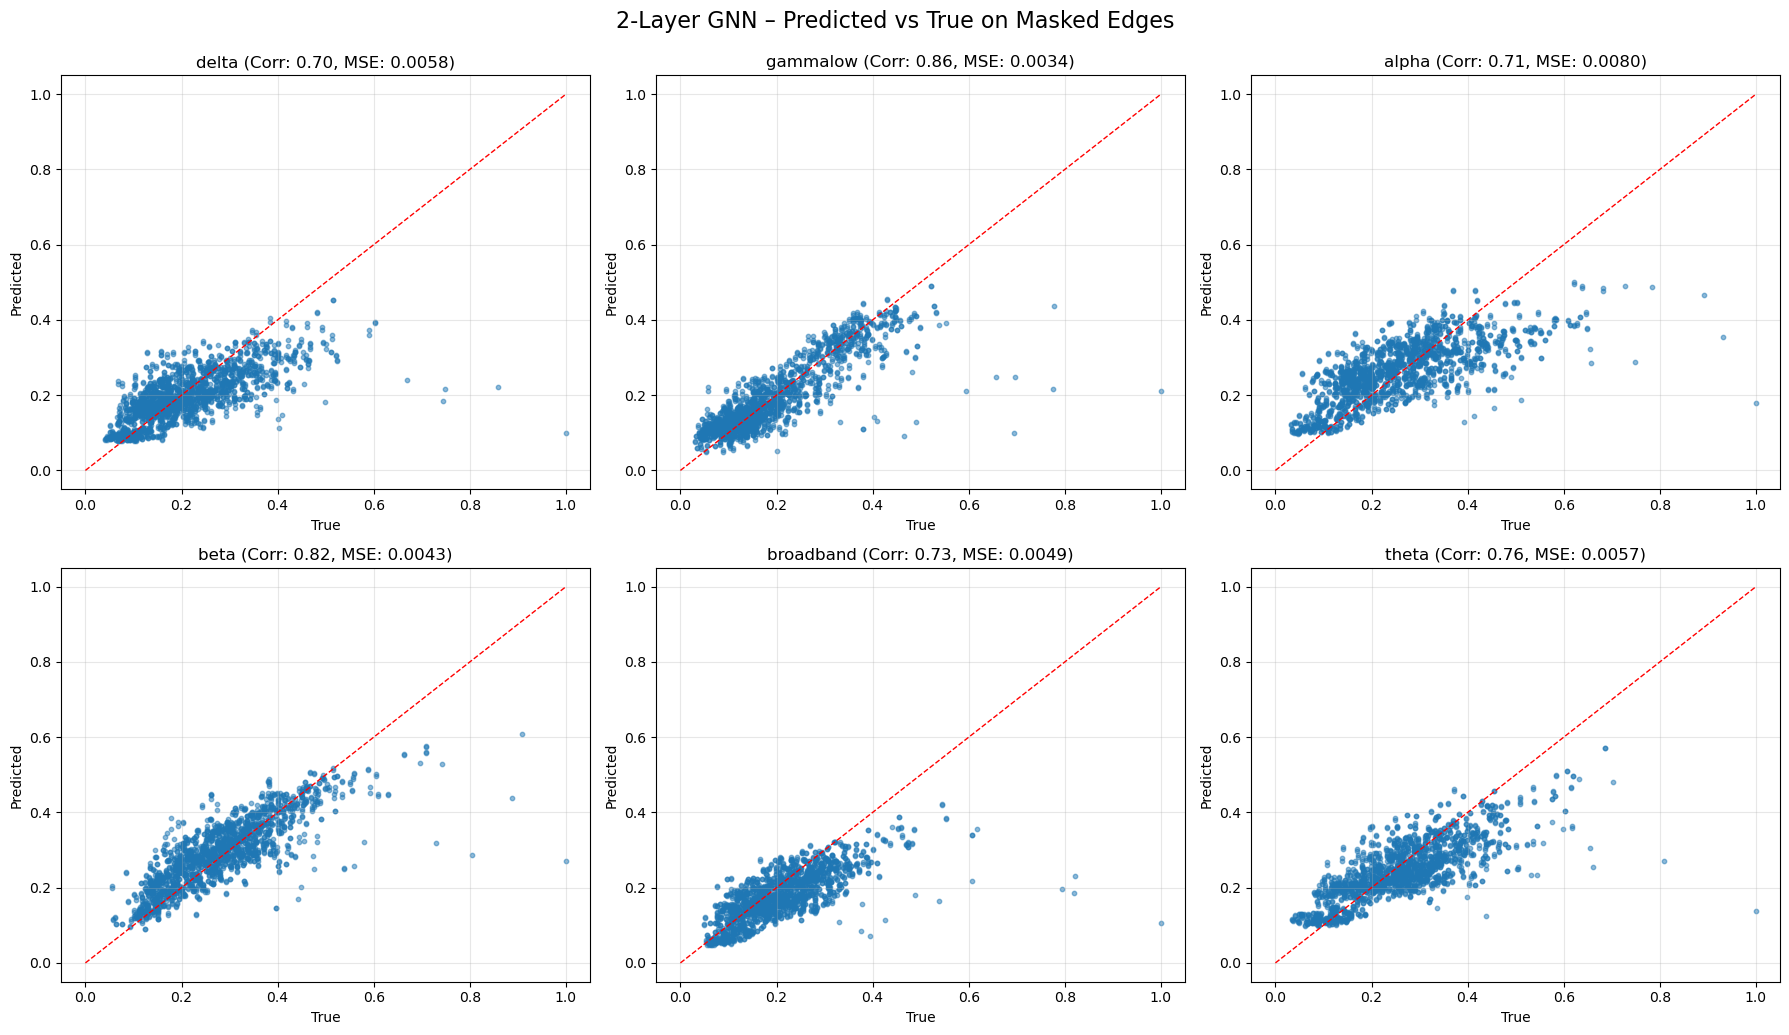

In [60]:
mse1, mae1, preds1, trues1 = evaluate_model(model_1layer, test_graphs, model_name="1-Layer GNN")
mse2, mae2, preds2, trues2 = evaluate_model(model_2layer, test_graphs, model_name="2-Layer GNN")
